In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image, ImageDraw,ImageFont
from itertools import combinations
import time
import sys
import os
import shutil
import requests

In [2]:
df = pd.read_csv('nono.csv')
sys.setrecursionlimit(1000)

In [3]:
from rich import print

## Nonodraw

In [4]:
def Nonodraw(n):
    '''Algorythom that draw image of the nonogram given its configuration'''
    col_matrix = n['col']
    row_matrix = n['row']
    canvas = n['canvas']

    col_matrix[col_matrix==0] = -5
    row_matrix[row_matrix==0] = -5
    canvas[canvas==-1] = -2
    canvas[canvas==1] = -1
  
    dmy = np.ones((col_matrix.shape[0], row_matrix.shape[1]))*-5
    tp = np.concatenate((dmy,col_matrix), axis=1)
    btm = np.concatenate((row_matrix,canvas), axis=1)
    board = np.concatenate((tp,btm), axis=0)
    h,w = tuple([100*i for i in board.shape])

    img = Image.new("RGB", (w, h))
    img1 = ImageDraw.Draw(img)

    
    font = ImageFont.truetype(r'/usr/share/fonts/noto/NotoSans-Light.ttf', 50)

    for i in range(board.shape[1]):
        for j in range(board.shape[0]):
            shape=[(100*i, 100*j),(100*(i+1), 100*(j+1))]
            img1.rectangle(shape, fill ="#CBE5F2", outline ="#000")
            if int(board.tolist()[j][i])!=0 and int(board.tolist()[j][i])!=-5:
                img1.text((100*(i+0.28), 100*(j+0.24)), str(int(board.tolist()[j][i])), fill ="black", font = font, align ="center") 
            if int(board.tolist()[j][i])==-1:
                img1.rectangle(shape, fill ="#000", outline ="#000")
            if int(board.tolist()[j][i])==-5:
                img1.rectangle(shape, fill ="#CBE5F2", outline ="#000")
            if int(board.tolist()[j][i])==-2:
                img1.rectangle(shape, fill ="white", outline ="#000")
            if int(board.tolist()[j][i])==0:
                img1.rectangle(shape, fill ="#ddd", outline ="#000")
    return img

## Part 1: Defining the intersection run

In [5]:
def Nonogram(mtx):
    '''Initializes Nonogram object without OOP :) '''
    canvas = np.zeros((mtx.sizeCol, mtx.sizeRow), dtype=int)

    col = [int(i) for i in mtx.rowClues.replace(' ','0').replace('\xa0','0').split(',')]
    col = np.asmatrix(col).reshape(len(col)//mtx.sizeRow, mtx.sizeRow)

    row = [int(i) for i in mtx.colClues.replace(' ','0').replace('\xa0','0').split(',')]
    row = np.asmatrix(row).reshape(mtx.sizeCol,len(row)//mtx.sizeCol)

    rc = [[i for i in row[j].tolist()[0] if i!=0] for j in range(len(row))]
    cc = [[i for i in col.T[j].tolist()[0] if i!=0] for j in range(len(col.T))]
    
    return {"canvas": canvas,
           "cc":cc,
           "rc":rc,
           "sizeCol": mtx.sizeCol,
           "sizeRow": mtx.sizeRow,
           "col": col,
           "row": row}

In [6]:
def heur(rc):
    ''' this function returns the number of cells 
    that will be left after filling the row with given row constraint'''
    return mtx.sizeCol-np.sum(rc)-np.count_nonzero(rc)+1

def order_heur(rc):
    '''This orders the row constraints based in the heur function'''
    ss =[(mtx.sizeCol-np.sum(i)-np.count_nonzero(i)+1,j) for j,i in enumerate(rc)]
    df = {'heur':[i[0] for i in ss],'ind':[i[1] for i in ss]}
#     reordered=pd.DataFrame(df).sort_values('heur').ind.tolist()
#     return {'list':rc[ reordered,:], "ind":reordered}
    return pd.DataFrame(df).sort_values('heur').ind.tolist()

In [7]:
def left(canvas, rc): # canvas, rc or canvas.T and cc
    '''calculates the leftmost run for given row constaint'''
    dec = canvas.copy()
    for i in order_heur(rc):
        lng , s = len(dec[i,:]) , 0
        for j,k in enumerate(rc[i]):
            for m in range(lng):
                s+=1
                if k!=m:
                    dec[i,:][s-1]=j+1
                else:
                    break    
    return dec

In [8]:
def right(canvas, rc): # canvas, rc or canvas.T and cc
    '''calculates the rightmost run for given row constaint'''
    dec = canvas.copy()
    for i in order_heur(rc):
        lng , s = len(dec[i,:]) , 0
        for j,k in reversed(list(enumerate(rc[i]))):
            for m in range(lng):
                s+=1
                if k!=m:
                    dec[i,:][lng-s]=j+1
                else:
                    break    
    return dec

In [9]:
def conj(canvas, rc):
    '''calculates the conjunction of the leftmost and rightmost runs'''
    lf = left(canvas,rc)
    rg = right(canvas,rc)
    ccc = canvas.copy()
    for i,_ in enumerate(lf):
        for j,_ in enumerate(lf[i]):
            if lf[i][j] == rg[i][j] and lf[i][j] != 0 and rg[i][j]!=0:
                ccc[i][j] = 1
    return ccc        

In [10]:
def superconj(n):
    '''calculates the conjunction of the row constraint 
    and column constraintes based on conj funciton'''
    rw = conj(n['canvas'], n['rc'])
    cw = conj(n['canvas'].T, n['cc']).T
    return np.asarray([[rw[i][j] or cw[i][j] for j,_ in enumerate(rw[i])] for i,_ in enumerate(rw)])

In [11]:
def verify(temp):
    '''verifies if any row constraint is satisfied or not
    and applies the satisfied rows to the actual nonogram matrix'''
    temp = superconj(n)
    for i,row in enumerate(temp):
        if sat(n['rc'][i],row):
            temp[i][temp[i]==0] = -1
    ctemp = superconj(n).T
    for i,col in enumerate(ctemp):
        if sat(n['cc'][i],col):
            ctemp[i][ctemp[i]==0] = -1
    return temp|ctemp.T

## Part 2: Generating the tree

In [12]:
def _cp(n_empty, groups, ones, cnv):
    '''helper function to generate the possible configurations for each constraint'''
    res_opts = []
    for p in combinations(range(groups+n_empty), groups):
        selected = [-1]*(groups+n_empty)
        ones_idx = 0
        for val in p:
            selected[val] = ones_idx
            ones_idx += 1
        res_opt = [ones[val]+[-1] if val > -1 else [-1] for val in selected]
        res_opt = [item for sublist in res_opt for item in sublist][:-1]
        tf = np.asarray(cnv)+np.asarray(res_opt)
        if len(tf[tf==0])==0:
            res_opts.append(res_opt)
    return res_opts

In [13]:
def create_possibilities(values, no_of_other):
    '''generates the possible configurations of each row constraint'''
    t = []

    for i,v in enumerate(values):
        groups = len(v)
        no_empty = no_of_other-sum(v)-groups+1
        ones = [[1]*x for x in v]
        res = _cp(no_empty, groups, ones, n['canvas'][i])
        t.append(res) 
    return t

## Part 3: Backtracking

In [14]:
def dfs_map(t):
    '''defining a python dict which describes the search tree
    i.e. the child parent relation of each constraint configurations'''
    s= 0
    p = []
    mp = {}
    for i in t:
        l = []
        for j in i:
            l.append(s)
            s+=1
        p.append(l)
    for i in range(len(p)-1):
        for j in p[i]:
            mp.update({str(j): [str(u) for u in p[i+1]]})
    for i in p[-1]:
        mp.update({str(i):[]})
    mp.update({'-1':[str(i) for i,_ in enumerate(t[0])]})
    return mp

In [15]:
def siblings(graph):    
    ''' returns the list of sibling configurations'''
    x = []
    x += [i for i in graph.values()]
    return x

In [16]:
def flatten(t):
    '''gives 1D array of all configurations of row constraints'''
    x = []
    for i in t:
        for k in i:
            x.append(k)
    return x

In [17]:
def sat(rc, temp_row):
    '''checks wheter the configuration satisfies corresponding row constraint'''
    strcheck=[str(i) for i in temp_row]
    cnvcheck=[str(i) for i in temp_row]
    k = [len(j) for j in ''.join(strcheck).split('0') if len(j)!=0]
    ck = [len(j) for j in ''.join(cnvcheck).split('0') if len(j)!=0]
    if (rc==k and heur(rc)==0) or ck==rc:
        return True
    else: 
        return False

In [18]:
def dfs(stack,graph,node,sbl):
    ''' the actual backtracking algorythm which 
    generates all possible configurations of the whole nonogram matrix'''
    stack+=graph[node][::-1]
    if int(node) > int(lst[-1]):
        lst.append(node)
    else:
        lst.pop()
        lst.append(node)
    for k in lst:
        if [i for i in sbl if lst[-1] in i] == [i for i in sbl if k in i] and [i for i in sbl if k in i]!=[]:
            while lst[-1] != k:
                lst.pop()
            lst.pop()
            lst.append(node)
    paths.append(lst[3:])
    if len(stack) == 0:
        return
    nxt=stack.pop()    
    dfs(stack,graph,nxt,sbl)

In [19]:
def compose_temp_canvas(conf):
    '''composes a configuration of nonogram matrix based on the order defined with backtracking algorythm'''
    temp = np.asarray([flatten(t)[int(i)] for i in conf])
    rest = n['canvas'][len(conf):]
    return np.concatenate((temp,rest), axis=0)

In [20]:
def cont(temp):
    ''' returns True wheter the nonogram configuration is applicable'''
    for i,j in enumerate(temp):
        rc = n['cc'][i]
        x = ''.join([str(i) for i in j]).split('-1')
        temp_const = [sum([int(j) for j in i]) for i in x]
        fn = [i for i in temp_const if i!=0]
#         print(all([a>=b for a,b in zip(rc,fn+[0]*(len(rc)-len(fn)))]), rc==fn+[0]*(len(rc)-len(fn)), rc,fn+[0]*(len(rc)-len(fn)))
        if rc==fn+[0]*(len(rc)-len(fn)):
            continue
        else:
            return False
    return True

In [21]:
def Solve(paths):
    '''function to iterate over matrix configurations and check for applicable configuration and return it'''
    for i in paths:
        ss = compose_temp_canvas(i).T
        if cont(ss):
            return ss.T

## Final testings

In [22]:
info = {}  # used for storing the times measures
p1 = []    # for storing iteration duration of first part
p2 = []    # for storing iteration duration of second part
p3 = []    # for storing iteration duration of third part
total = [] # for storing total runtime of the algorythm
size = []  # for storing the sizes of each considered nonogram
rec = []   # stores the nonogram index from the nono.csv dataframe which are complex 
           #     and the machine doesn't have the power to run dfs on them

df = pd.read_csv('nono.csv')

# order the dataframe to run the easiest puzzles at first then increasing the complxity
ss = df.sort_values(['sizeCol','sizeRow']).iloc[:157,:] # providing higher number may make 
                                                        # algorythm to run really long

for hh,_ in enumerate(ss.iterrows()):
    try:
        if hh not in rec:
            t1 = time.time()
            mtx=ss.iloc[hh,:]
            n = Nonogram(mtx)
            n['canvas'] = verify(superconj(n))
            t2 = time.time()

            t = create_possibilities(n['rc'], n['sizeRow'])

            t3 = time.time()

            stack = []
            node='-1'
            lst = ['-5','-2']
            paths = []
            graph = dfs_map(t)
            sbl= siblings(graph)
            dfs(stack,graph,node,sbl)
            n['canvas'] = Solve(paths[1:])
            t4 = time.time()

            p1.append(t2-t1)
            p2.append(t3-t2)
            p3.append(t4-t3)
            total.append(t4-t1)
            size.append(n['sizeCol']*n['sizeRow'])
            info.update({'p1':p1,'p2':p2,'p3':p3,'total':total,'size':size})


            img_data = requests.get(mtx.solution).content
            with open(f'Images/{hh}_sol.jpg', 'wb') as handler:
                handler.write(img_data)
            Nonodraw(n).save(f'Images/{hh}.jpg')

            image1 = Image.open(f'Images/{hh}_sol.jpg')
            image2 = Image.open(f'Images/{hh}.jpg')
            image1_size = image1.size
            image2_size = image2.size
            image2 = image2.resize(image1.size)
            new_image = Image.new('RGB',(2*image1_size[0], image1_size[1]), (250,250,250))
            new_image.paste(image1,(0,0))
            new_image.paste(image2,(image1_size[0],0))
            new_image.save(f"Images/Both/{hh}.jpg","JPEG")
    except RecursionError: # used to avid the recursionLimit error, so it doesn't fry my cpu :)
        rec.append(hh) # storing the 'difficult' ones just in case

In [23]:
# cleaning up the ./Images directory
filelist = [ f for f in os.listdir('./Images') if f.endswith(".jpg") ]
for f in filelist:
    os.remove(os.path.join('./Images', f))

## Results

Actually you can find the solved puzzle images in the 
    ```./Images/Both```
    directory. 
   
Some examples. Left part is the actual solution and the right one is the solution of the algorythm

![Sample](./Images/Both/103.jpg)
![Sample](./Images/Both/106.jpg)
![Sample](./Images/Both/154.jpg)
![Sample](./Images/Both/156.jpg)

### Below is the runtime complexty graph.

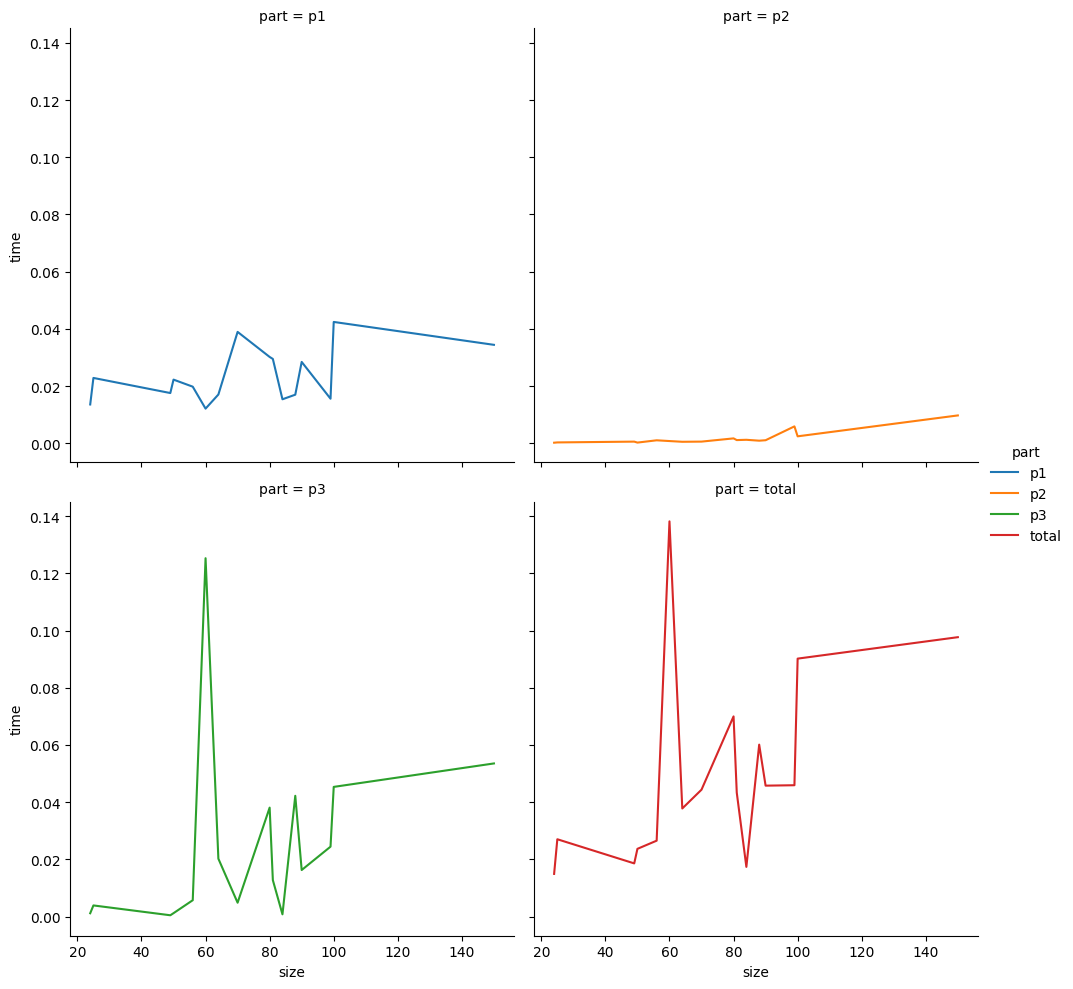

In [25]:
# plotting the results
dd = pd.DataFrame(info)
gg = dd.groupby('size').mean()
rr = gg.stack().reset_index()
rr.columns= ['size','part','time']

sns.relplot(
    data=rr,
    x="size", y="time",
    hue="part", col="part",
    kind="line",
    col_wrap=2
).savefig('graphs.png')

# END